# 🐫 CAMEL VLM Agent

In [ ]:
import os
from getpass import getpass
import matplotlib.pyplot as plt
# Prompt for the API key securely
os.environ["OPENAI_API_KEY"] = "PUT YOUR API TOKEN HERE"

In [2]:
from camel.agents import ChatAgent
from camel.configs import ChatGPTConfig
from camel.messages import BaseMessage
from camel.types import ModelType, ModelPlatformType
from camel.types.enums import RoleType
from camel.models import ModelFactory


sys_msg = BaseMessage.make_assistant_message(
    role_name="Assistant",
    content="You're a helpful assistant",
)

# Set model
model=ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O,
    model_config_dict=ChatGPTConfig(temperature=0.6).as_dict(),
)

# Set agent
vlm_agent = ChatAgent(
    sys_msg,
    model=model
)

## Initialize MineDojo 

In [3]:
import minedojo
import numpy as np
from PIL import Image

# Add MINEDOJO_HEADLESS=1 to your environment variables to run this script headless
os.environ["MINEDOJO_HEADLESS"] = "1" 
 
env = minedojo.make(
    task_id="harvest_1_log",
    image_size=(288, 512),
    world_seed=23,
    seed=42,
)
task_prompt, task_guidance = minedojo.tasks.ALL_PROGRAMMATIC_TASK_INSTRUCTIONS['harvest_1_log']
print('task_prompt:', task_prompt)
print('task_guidance:', task_guidance)

print(f"[INFO] Create a task with prompt: {env.task_prompt}")

[INFO:minedojo.tasks] Loaded 1581 Programmatic tasks, 1560 Creative tasks, and 1 special task: "Playthrough". Totally 3142 tasks loaded.


task_prompt: obtain log
task_guidance: 1. Find a tree.
2. Cut the tree down with an axe.
3. Collect the logs that appear.
[INFO] Create a task with prompt: obtain log


/home/cjunting/data/miniforge3/envs/alpha_craft/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


## Initialize the OASIS 

Please refer to [open-oasis](open-oasis/README.md) for oasis model download. 

In [ ]:
import torch
from open_oasis.world_model import WorldModel

oasis_ckpt = "path/to/oasis_checkpoint.pt"
vae_ckpt = "path/to/vae_checkpoint.pt"

world_model = WorldModel(
    oasis_ckpt=oasis_ckpt,
    vae_ckpt=vae_ckpt,
    num_frames=32,
    n_prompt_frames=1,
    ddim_steps=10,
    fps=20,
    scaling_factor=0.07843137255,
    max_noise_level=1000,
    noise_abs_max=20,
    stabilization_level=15,
    seed=0,
    device="cuda:3"
)

Loading Oasis-500M from /data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/oasis500m.safetensors...
Loading ViT-VAE-L/20 from /data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/vit-l-20.safetensors...


## Run single step in the OASIS and MineDojo

In [34]:
task_prompt, task_guidance = minedojo.tasks.ALL_PROGRAMMATIC_TASK_INSTRUCTIONS['harvest_1_log']
print('task_prompt:', task_prompt)
print('task_guidance:', task_guidance)

print(f"[INFO] Create a task with prompt: {env.task_prompt}")

obs = env.reset()

obs_img = np.array(obs['rgb'])
obs_img = np.transpose(obs_img, (1, 2, 0))

image = Image.fromarray(obs_img.astype('uint8'))

task_prompt: obtain log
task_guidance: 1. Find a tree.
2. Cut the tree down with an axe.
3. Collect the logs that appear.
[INFO] Create a task with prompt: obtain log


(-0.5, 511.5, 287.5, -0.5)

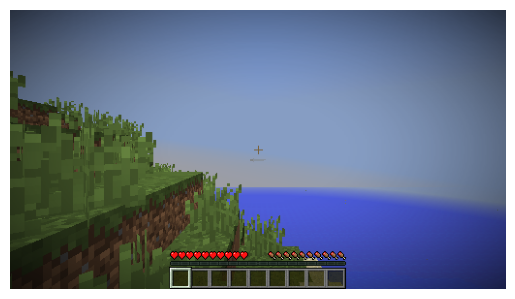

In [35]:
# show the image
plt.imshow(image)
plt.axis('off')

Generating frames: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


(-0.5, 639.5, 359.5, -0.5)

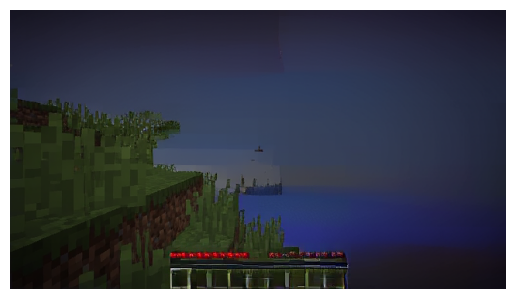

In [36]:
# Use OASIS world model to guess the next state
prompt_tensor = torch.tensor(obs_img).permute(2, 0, 1).unsqueeze(0).float()
# Camera is quantized to [0-79] for both x and y, 40 means no movement
action_dict = {"move_forward": 1, "camera": [40,40]}
next_state = world_model.step_single_action(prompt_tensor, action_dict)

# Display the next state
# next_state_img = np.transpose(next_state, (1, 2, 0))
next_state_image = Image.fromarray(next_state)

# show the image
plt.imshow(next_state_image)
plt.axis('off')

Keys of obs: dict_keys(['rgb', 'inventory', 'equipment', 'life_stats', 'location_stats', 'nearby_tools', 'damage_source', 'voxels', 'masks', 'delta_inv'])


(-0.5, 511.5, 287.5, -0.5)

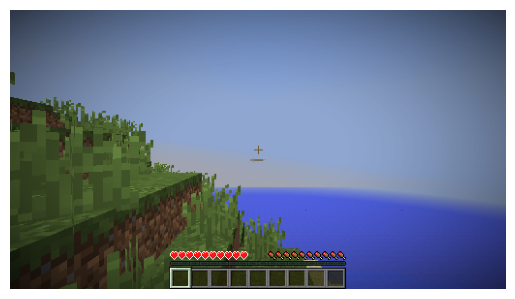

In [39]:
# Run the same action in the minedojo environment
action = env.action_space.no_op()  # empty action
action[0] = 1  # move forward
obs, reward, done, info = env.step(action)
# print("obs:", obs["rgb"])
print("Keys of obs:", obs.keys())

obs_img = np.array(obs["rgb"])
obs_img = np.transpose(obs_img, (1, 2, 0))

image = Image.fromarray(obs_img.astype("uint8"))
plt.imshow(image)
plt.axis("off")

In [ ]:
# Close the environment
env.close()